## Acne Severity Detection

### EfficientNetB0 model with ImageDataGenerator

In [26]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [27]:
# Data Directory and Categories
data_dir = 'New_Severity_Dataset'
categories = ['Level 0', 'Level 1', 'Level 2', 'Level 3']
img_height, img_width = 224, 224
batch_size = 16

In [28]:
# Function to Load Images and Labels
def load_data(data_dir, categories):
    images, labels = [], []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_width, img_height))
            images.append(img)
            labels.append(categories.index(category))
    return np.array(images), np.array(labels)

In [29]:
import os

data_dir = 'New_Severity_Dataset'
print("Does data directory exist?", os.path.exists(data_dir))

for category in categories:
    category_path = os.path.join(data_dir, category)
    print(f"Checking: {category_path} -> Exists? {os.path.exists(category_path)}")

Does data directory exist? True
Checking: New_Severity_Dataset\Level 0 -> Exists? True
Checking: New_Severity_Dataset\Level 1 -> Exists? True
Checking: New_Severity_Dataset\Level 2 -> Exists? True
Checking: New_Severity_Dataset\Level 3 -> Exists? True


In [30]:
# Load and Normalize Data
images, labels = load_data(data_dir, categories)
images = images / 255.0

In [31]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [32]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [33]:
# EfficientNetB0 Model with Additional Layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))
base_model.trainable = True  # Enable fine-tuning

In [34]:
model1 = Sequential([
    base_model,
    BatchNormalization(),
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

In [35]:
# Compile Model with Optimized Learning Rate
model1.compile(optimizer=Adam(learning_rate=0.00005), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [36]:
# Train Model with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

history = model1.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=1)

d:\GitHub\Acne_severe\model\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.2939 - loss: 1.4085 - val_accuracy: 0.2606 - val_loss: 1.3808
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 145s 1s/step - accuracy: 0.3735 - loss: 1.2913 - val_accuracy: 0.2366 - val_loss: 1.3952
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 152s 1s/step - accuracy: 0.4339 - loss: 1.1380 - val_accuracy: 0.3697 - val_loss: 1.3457
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 153s 1s/step - accuracy: 0.4905 - loss: 1.0779 - val_accuracy: 0.3013 - val_loss: 1.2929
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 155s 1s/step - accuracy: 0.5199 - loss: 1.0074 - val_accuracy: 0.3678 - val_loss: 1.2990
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5368 - loss: 0.9361 - val_accuracy: 0.3752 - val_loss: 1.2801
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.5592 - loss: 0.9334 - val_accuracy: 0.3586 - val_loss: 1.2727
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - accuracy: 0.5771 - loss: 0.8745 - val_accu

In [37]:
# Evaluate Model
val_loss, val_acc = model1.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 6s 374ms/step - accuracy: 0.4833 - loss: 1.6465
Validation Accuracy: 0.4806


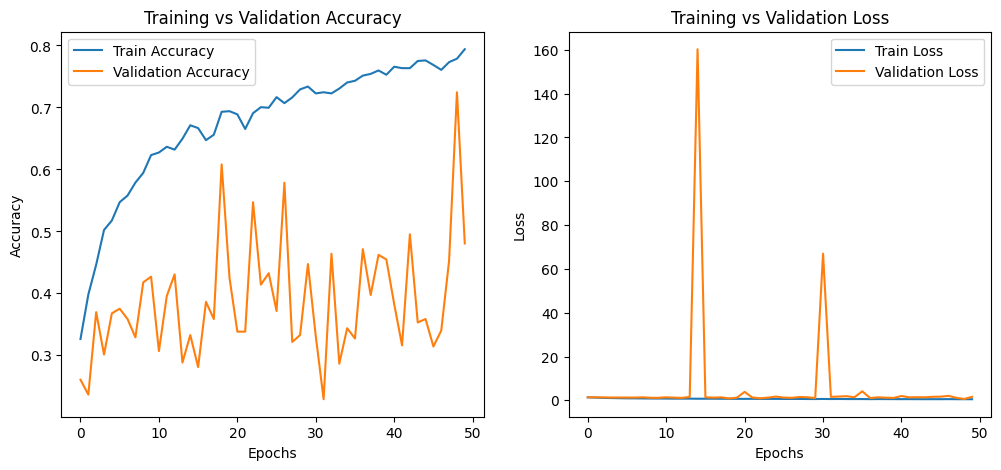

In [40]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


In [41]:
model1.save("ENetB0_model.h5")

### Changed the model structure to Custom CNN

In [42]:
# Custom CNN Model
model2 = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

d:\GitHub\Acne_severe\model\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [43]:
# Compile Model with Optimized Learning Rate
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [44]:
# Train Model with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

In [45]:
history2 = model2.fit(datagen.flow(X_train, y_train, batch_size=batch_size),
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=1)

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 89s 626ms/step - accuracy: 0.3181 - loss: 4.5566 - val_accuracy: 0.1793 - val_loss: 23.6773
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 83s 612ms/step - accuracy: 0.2983 - loss: 2.0908 - val_accuracy: 0.1793 - val_loss: 21.6918
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 678ms/step - accuracy: 0.3577 - loss: 2.0397 - val_accuracy: 0.1793 - val_loss: 16.3064
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 688ms/step - accuracy: 0.3829 - loss: 2.0083 - val_accuracy: 0.2089 - val_loss: 9.6695
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 684ms/step - accuracy: 0.3631 - loss: 1.9722 - val_accuracy: 0.3919 - val_loss: 5.1793
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 684ms/step - accuracy: 0.3621 - loss: 1.9808 - val_accuracy: 0.3549 - val_loss: 4.4201
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 93s 686ms/step - accuracy: 0.3313 - loss: 1.9677 - val_accuracy: 0.4381 - val_loss: 2.4983
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 92s 683ms/step - accuracy: 0.3493 - loss

In [46]:
# Evaluate Model
val_loss, val_acc = model2.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step - accuracy: 0.4498 - loss: 1.4503
Validation Accuracy: 0.4455


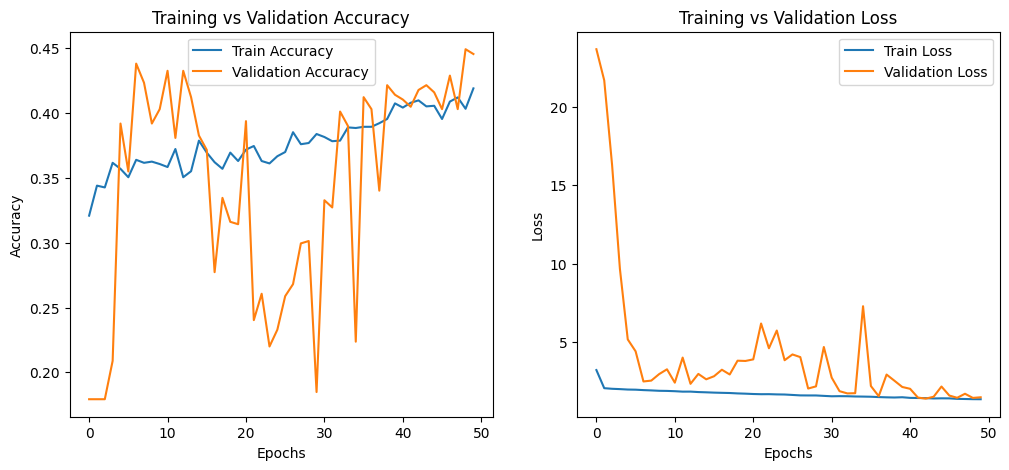

In [48]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

### Moving forward with different approach in Image Preprocessing

In [49]:
# Function to Load Images and Labels
def load_data(data_dir, categories):
    images, labels = [], []
    for category in categories:
        category_path = os.path.join(data_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_width, img_height))
            images.append(img)
            labels.append(categories.index(category))
    return np.array(images), np.array(labels)

# Load and Normalize Data
images, labels = load_data(data_dir, categories)
images = images / 255.0

In [50]:
# Train-Test Split
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

In [51]:
# Custom CNN Model
model3 = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    Flatten(),
    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.4),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

d:\GitHub\Acne_severe\model\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [52]:
# Compile Model with Optimized Learning Rate
model3.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train Model with Early Stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)

history3 = model3.fit(X_train, y_train, batch_size=batch_size,
                    validation_data=(X_val, y_val),
                    epochs=50,
                    verbose=1)

Epoch 1/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 88s 625ms/step - accuracy: 0.3223 - loss: 4.7474 - val_accuracy: 0.2643 - val_loss: 5.0184
Epoch 2/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 90s 667ms/step - accuracy: 0.3505 - loss: 2.0701 - val_accuracy: 0.2736 - val_loss: 3.3265
Epoch 3/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 91s 677ms/step - accuracy: 0.3691 - loss: 2.0223 - val_accuracy: 0.3142 - val_loss: 3.9203
Epoch 4/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 123s 912ms/step - accuracy: 0.3836 - loss: 1.9922 - val_accuracy: 0.3420 - val_loss: 3.3347
Epoch 5/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 107s 644ms/step - accuracy: 0.3955 - loss: 1.9484 - val_accuracy: 0.3586 - val_loss: 3.0891
Epoch 6/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 89s 660ms/step - accuracy: 0.3984 - loss: 1.9136 - val_accuracy: 0.3882 - val_loss: 2.6307
Epoch 7/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 89s 659ms/step - accuracy: 0.3776 - loss: 1.9133 - val_accuracy: 0.4251 - val_loss: 2.2395
Epoch 8/50
135/135 ━━━━━━━━━━━━━━━━━━━━ 89s 658ms/step - accuracy: 0.4135 - loss:

In [53]:
# Evaluate Model
val_loss, val_acc = model3.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.4f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 173ms/step - accuracy: 0.4383 - loss: 1.4838
Validation Accuracy: 0.4325


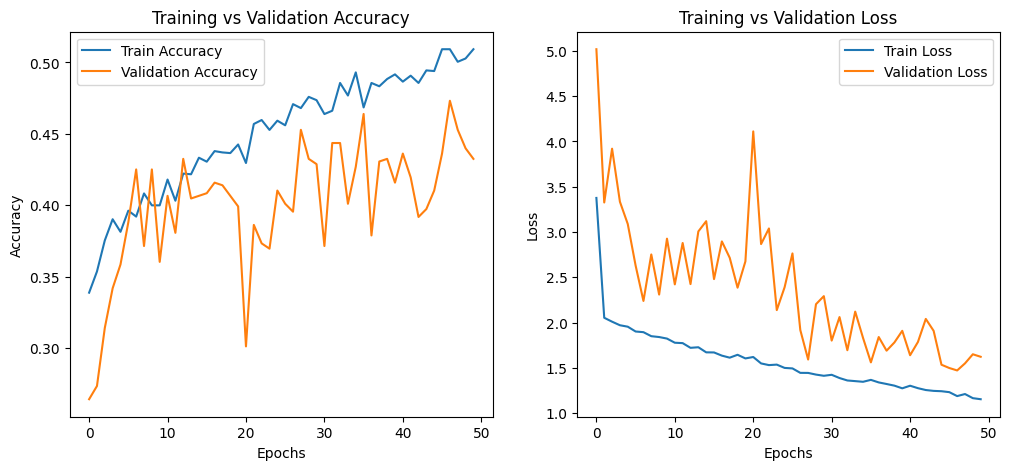

In [54]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history3.history['accuracy'], label='Train Accuracy')
plt.plot(history3.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

### Used different CNN with alterations in the layers

In [65]:
import numpy as np
from PIL import Image
from glob import glob
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
import cv2

# Initialize empty lists to store images and labels
X = []
Y = []

In [66]:
# Directories for each face direction (bottom, top, left, right)
directions = ['Level 0', 'Level 1', 'Level 2', 'Level 3']
image_directory = 'New_Severity_Dataset'  # Replace with the actual path
img_height, img_width = 224, 224  # Resizing dimensions
batch_size = 16

# Function to load images and check counts
def load_data(data_dir, categories):
    images, labels = [], []
    class_counts = {category: 0 for category in categories}  # Track per-class count

    for category in categories:
        category_path = os.path.join(data_dir, category)
        if not os.path.exists(category_path):
            print(f"⚠️ Warning: Folder {category_path} does not exist!")
            continue

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # Skip non-image files
            if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue

            img = cv2.imread(img_path)
            if img is None:
                print(f"❌ Error: Could not read {img_path}")
                continue

            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_width, img_height))

            images.append(img)
            labels.append(categories.index(category))
            class_counts[category] += 1  # Update count

    print("✅ Class distribution:", class_counts)
    return np.array(images), np.array(labels)

In [67]:
# Load dataset
X, Y = load_data(image_directory, directions)

✅ Class distribution: {'Level 0': 714, 'Level 1': 906, 'Level 2': 597, 'Level 3': 484}


In [68]:
# One-hot encode labels
Y = to_categorical(Y, num_classes=len(directions))

In [69]:
# Check unique classes in the one-hot encoded labels
unique_classes = np.argmax(Y, axis=1)  # Convert one-hot to integer labels
class_counts = np.unique(unique_classes, return_counts=True)

# Display the unique classes and their counts
for label, count in zip(class_counts[0], class_counts[1]):
    print(f"Class {label}: {count} samples")

Class 0: 714 samples
Class 1: 906 samples
Class 2: 597 samples
Class 3: 484 samples


In [70]:
print("Dataset successfully loaded!")
print(f"X shape: {X.shape}, Y shape: {Y.shape}")  # Debugging output

Dataset successfully loaded!
X shape: (2701, 224, 224, 3), Y shape: (2701, 4)


In [71]:
# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

In [72]:
# Check unique classes in the one-hot encoded labels
unique_classes = np.argmax(y_train, axis=1)  # Convert one-hot to integer labels
class_counts = np.unique(unique_classes, return_counts=True)

# Display the unique classes and their counts
for label, count in zip(class_counts[0], class_counts[1]):
    print(f"Class {label}: {count} samples")

Class 0: 564 samples
Class 1: 723 samples
Class 2: 477 samples
Class 3: 396 samples


In [73]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model4 = Sequential()

# First convolutional block
model4.add(Conv2D(32, (3, 3), padding='same', input_shape=(224, 224, 3), activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

# Second convolutional block
model4.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model4.add(MaxPooling2D(pool_size=(2, 2)))
model4.add(Dropout(0.3))

# Flatten layer
model4.add(Flatten())

# Fully connected layer
model4.add(Dense(64, activation='relu'))
model4.add(Dropout(0.4))  # Increased dropout to prevent overfitting

# Output layer (4 classes, softmax)
model4.add(Dense(4, activation='softmax'))

# Compile the model
model4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model4.summary()


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │    12,845,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,864,772 (49.08 MB)

 Trainable params: 12,864,772 (49.08 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the checkpoint callback to save the best model during training
checkpoint = ModelCheckpoint(
    'face_direction_model.keras',  # Save the model as a .h5 file
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',
    verbose=1
)

# Train the model
history4 = model4.fit(
    x_train, y_train,  # Training data
    validation_data=(x_test, y_test),  # Validation data
    epochs=50,  # Number of epochs
    batch_size=32,  # Batch size
    callbacks=[checkpoint]  # Use the checkpoint callback
)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.2626 - loss: 478.7200
Epoch 1: val_loss improved from inf to 1.38370, saving model to face_direction_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 28s 383ms/step - accuracy: 0.2626 - loss: 473.9333 - val_accuracy: 0.3253 - val_loss: 1.3837
Epoch 2/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step - accuracy: 0.3238 - loss: 1.3850
Epoch 2: val_loss improved from 1.38370 to 1.37620, saving model to face_direction_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 26s 386ms/step - accuracy: 0.3239 - loss: 1.3848 - val_accuracy: 0.3420 - val_loss: 1.3762
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.3373 - loss: 1.3629
Epoch 3: val_loss improved from 1.37620 to 1.36873, saving model to face_direction_model.keras
68/68 ━━━━━━━━━━━━━━━━━━━━ 27s 401ms/step - accuracy: 0.3374 - loss: 1.3626 - val_accuracy: 0.3604 - val_loss: 1.3687
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.3346 - loss: 1.3162
Epoch 4: val_loss

In [76]:
# Evaluate the model on the test set
test_loss, test_acc = model4.evaluate(x_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

17/17 - 1s - 75ms/step - accuracy: 0.6470 - loss: 1.1919
Test accuracy: 0.6469500660896301


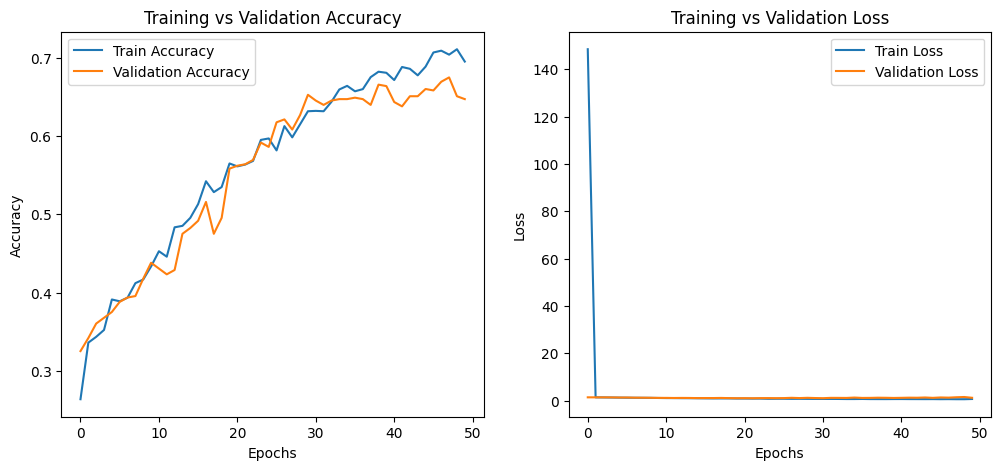

In [83]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history4.history['accuracy'], label='Train Accuracy')
plt.plot(history4.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()


### Changed the model architecture with VGG16 base model

In [90]:
#Importing libraries
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix
from sklearn import preprocessing

#tensorflow libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, Sequential
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [91]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 20

# Load the DataFrame
path = "New_Severity_Dataset"
data = {"imgpath": [], "labels": []}
category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
df = pd.DataFrame(data)

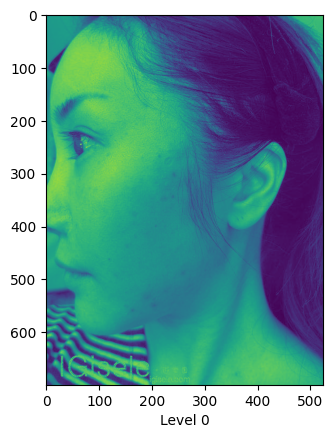

In [92]:
filepath = "New_Severity_Dataset/Level 0"

for img_path in os.listdir(filepath):
    img = cv2.imread(os.path.join(filepath, img_path), 0)
    plt.imshow(img)
    plt.xlabel(filepath.split("/")[-1])
    plt.show()   
    break

In [93]:
# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, train_size=0.70, shuffle=True, random_state=124)
valid_df, test_df = train_test_split(temp_df, train_size=0.70, shuffle=True, random_state=124)

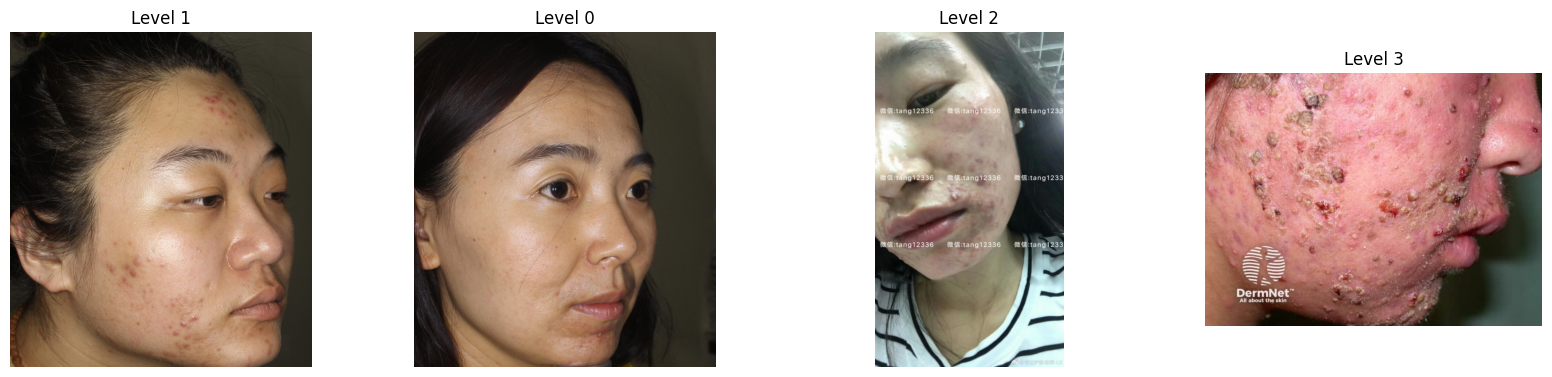

In [94]:
#Defining size of displayed image
plt.figure(figsize=(20,20))

#Displaying images from test dataframe
for i, row in test_df.sample(n=4).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [95]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["labels"])
valid_labels = label_encoder.transform(valid_df["labels"])
test_labels = label_encoder.transform(test_df["labels"])

In [96]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded vectors
num_classes = len(set(train_labels))
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [97]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define function to load and preprocess images
def load_images(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load and preprocess train, validation, and test images
train_images = load_images(train_df["imgpath"])
valid_images = load_images(valid_df["imgpath"])
test_images = load_images(test_df["imgpath"])

In [99]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define custom callback to stop training once the accuracy reaches 0.9
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        print(f"Validation Accuracy at epoch {epoch + 1}: {val_accuracy}")
        if val_accuracy >= 0.9:
            print("\nReached 90% accuracy! Stopping training...")
            self.model.stop_training = True

# Load the pre-trained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the convolutional base
base_model.trainable = False

# Build the model
model5 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dense(num_classes, activation="softmax")
])

In [100]:
# Compile the model
model5.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [101]:
model5.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [102]:
# Train the model with the custom callback
history5 = model5.fit(
    x=train_images, y=train_labels,
    validation_data=(valid_images, valid_labels),
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    callbacks=[MyCallback()]
)

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 909ms/step - accuracy: 0.3669 - loss: 2.7401Validation Accuracy at epoch 1: 0.5555555820465088
119/119 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - accuracy: 0.3675 - loss: 2.7310 - val_accuracy: 0.5556 - val_loss: 0.9984
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6582 - loss: 0.8096Validation Accuracy at epoch 2: 0.4426807761192322
119/119 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6580 - loss: 0.8100 - val_accuracy: 0.4427 - val_loss: 1.2706
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 833ms/step - accuracy: 0.6803 - loss: 0.7254Validation Accuracy at epoch 3: 0.6119929552078247
119/119 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.6803 - loss: 0.7253 - val_accuracy: 0.6120 - val_loss: 1.0320
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 834ms/step - accuracy: 0.7937 - loss: 0.5314Validation Accuracy at epoch 4: 0.631393313407898
119/119 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.7934 - loss: 0.5319 - val_accuracy: 0.6314

In [103]:
# Evaluate the model
test_loss, test_accuracy = model5.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.7598 - loss: 0.8452
Test Loss: 0.9400574564933777
Test Accuracy: 0.7172130942344666


In [104]:
# Save the model
model5.save("acne_severe_VGG.h5")

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history5.history['accuracy'], label='Train Accuracy')
plt.plot(history5.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

### Tried a different approach using layer changes with VGG16 and preprocessing

In [1]:
#Importing libraries
import cv2
import glob
import os
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score , confusion_matrix
from sklearn import preprocessing

#tensorflow libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, Model, Sequential
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 10

# Load the DataFrame
path = "New_Severity_Dataset"
data = {"imgpath": [], "labels": []}
category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path, folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)
df = pd.DataFrame(data)

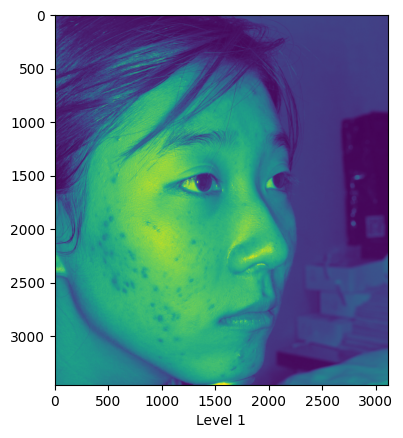

In [4]:
filepath = "New_Severity_Dataset/Level 1"

for img_path in os.listdir(filepath):
    img = cv2.imread(os.path.join(filepath, img_path), 0)
    plt.imshow(img)
    plt.xlabel(filepath.split("/")[-1])
    plt.show()   
    break

In [5]:
# Split the DataFrame into train, validation, and test sets
train_df, temp_df = train_test_split(df, train_size=0.70, shuffle=True, random_state=124)
valid_df, test_df = train_test_split(temp_df, train_size=0.70, shuffle=True, random_state=124)

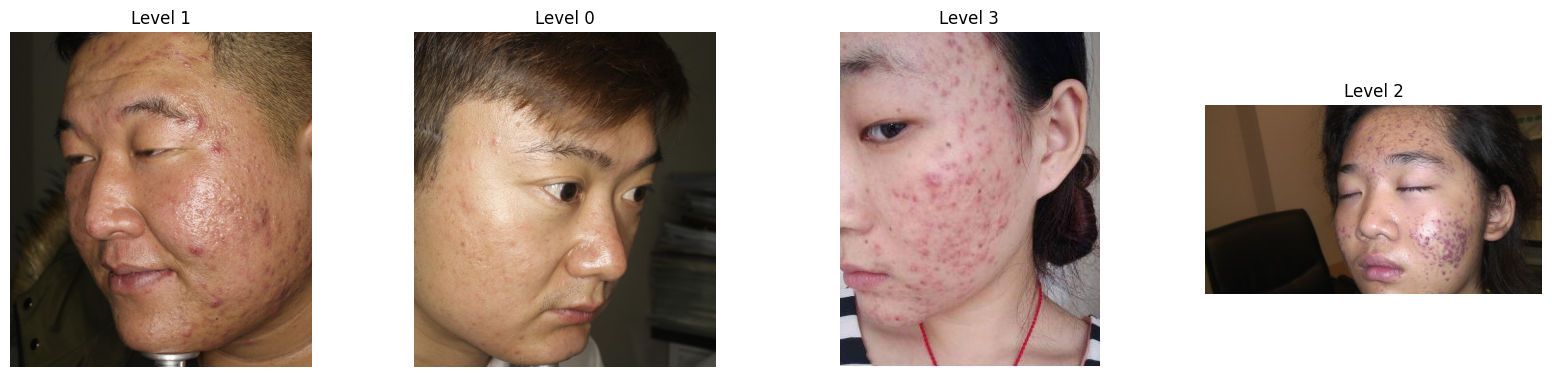

In [6]:
#Defining size of displayed image
plt.figure(figsize=(20,20))

#Displaying images from test dataframe
for i, row in test_df.sample(n=4).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder

# Encode labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_df["labels"])
valid_labels = label_encoder.transform(valid_df["labels"])
test_labels = label_encoder.transform(test_df["labels"])

In [8]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoded vectors
num_classes = len(set(train_labels))
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [9]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define function to load and preprocess images
def load_images(image_paths):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=IMAGE_SIZE)
        img = img_to_array(img)
        img = img / 255.0  # Normalize pixel values
        images.append(img)
    return np.array(images)

# Load and preprocess train, validation, and test images
train_images = load_images(train_df["imgpath"])
valid_images = load_images(valid_df["imgpath"])
test_images = load_images(test_df["imgpath"])

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Define custom callback to stop training once the accuracy reaches 0.9
class MyCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        print(f"Validation Accuracy at epoch {epoch + 1}: {val_accuracy}")
        if val_accuracy >= 0.9:
            print("\nReached 90% accuracy! Stopping training...")
            self.model.stop_training = True

# Load the pre-trained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))

# Freeze the convolutional base
base_model.trainable = False

# Build the model
model6 = Sequential([
    base_model,
    Flatten(),
    Dense(256, activation="relu"),
    Dense(num_classes, activation="softmax")
])

In [ ]:
# Compile the model
model6.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])


In [ ]:
model6.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,138,500 (80.64 MB)

 Trainable params: 6,423,812 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model with the custom callback
history6 = model6.fit(
    x=train_images, y=train_labels,
    validation_data=(valid_images, valid_labels),
    batch_size=BATCH_SIZE, epochs=EPOCHS,
    callbacks=[MyCallback()]
)

Epoch 1/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 817ms/step - accuracy: 0.3903 - loss: 3.2405Validation Accuracy at epoch 1: 0.43209877610206604
119/119 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.3908 - loss: 3.2291 - val_accuracy: 0.4321 - val_loss: 1.4635
Epoch 2/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.6080 - loss: 0.9257Validation Accuracy at epoch 2: 0.6437389850616455
119/119 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.6083 - loss: 0.9250 - val_accuracy: 0.6437 - val_loss: 0.8494
Epoch 3/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 823ms/step - accuracy: 0.7362 - loss: 0.6077Validation Accuracy at epoch 3: 0.6296296119689941
119/119 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.7361 - loss: 0.6079 - val_accuracy: 0.6296 - val_loss: 0.8898
Epoch 4/10
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - accuracy: 0.7604 - loss: 0.5424Validation Accuracy at epoch 4: 0.6578482985496521
119/119 ━━━━━━━━━━━━━━━━━━━━ 125s 1s/step - accuracy: 0.7605 - loss: 0.5423 - val_accuracy: 0

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model6.evaluate(test_images, test_labels)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7743 - loss: 0.6842
Test Loss: 0.7665778398513794
Test Accuracy: 0.7377049326896667


In [ ]:
# Save the model
model6.save("best_acne_severe.h5")

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history6.history['accuracy'], label='Train Accuracy')
plt.plot(history6.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history6.history['loss'], label='Train Loss')
plt.plot(history6.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()

### Using Image data generator for preprocessing

In [16]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [17]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [18]:
# Load and preprocess train, validation, and test images
train_images = train_datagen.flow(np.array(train_images), train_labels, batch_size=BATCH_SIZE)
valid_images = valid_datagen.flow(np.array(valid_images), valid_labels, batch_size=BATCH_SIZE)
test_images = test_datagen.flow(np.array(test_images), test_labels, batch_size=BATCH_SIZE)


In [19]:
# Load the pre-trained VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers of VGG16 for fine-tuning
for layer in base_model.layers[-4:]:  # Unfreezing last 4 layers
    layer.trainable = True


In [ ]:
# Build the model
model7 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation="relu"),
    Dropout(0.4),
    Dense(256, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")
])

# Compile the model with a lower learning rate
optimizer = Adam(learning_rate=0.0001)
model7.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

In [21]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
# Train the model
history7 = model7.fit(
    train_images,
    validation_data=valid_images,
    epochs=30,  # More epochs with early stopping
    batch_size=BATCH_SIZE,
    callbacks=[lr_scheduler, early_stopping]
)

d:\GitHub\Acne_severe\model\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 488s 4s/step - accuracy: 0.3363 - loss: 1.3554 - val_accuracy: 0.1728 - val_loss: 291.1496 - learning_rate: 1.0000e-04
Epoch 2/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 542s 5s/step - accuracy: 0.4015 - loss: 1.2033 - val_accuracy: 0.2011 - val_loss: 205.3887 - learning_rate: 1.0000e-04
Epoch 3/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 962s 8s/step - accuracy: 0.4178 - loss: 1.1737 - val_accuracy: 0.1728 - val_loss: 732.4423 - learning_rate: 1.0000e-04
Epoch 4/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.4127 - loss: 1.1369 - val_accuracy: 0.2822 - val_loss: 2228.9414 - learning_rate: 1.0000e-04
Epoch 5/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4127 - loss: 1.1739
Epoch 5: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
119/119 ━━━━━━━━━━━━━━━━━━━━ 1245s 11s/step - accuracy: 0.4127 - loss: 1.1737 - val_accuracy: 0.2822 - val_loss: 1322.7804 - learning_rate: 1.0000e-04
Epoch 6/30
119/119 ━━━━━━━━━━━━━━━━━━━━ 741s 6s/st

In [ ]:
# Evaluate the model on test data
test_loss, test_accuracy = model7.evaluate(test_images)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 13s 769ms/step - accuracy: 0.2319 - loss: 195.5986
Test Accuracy: 25.82%


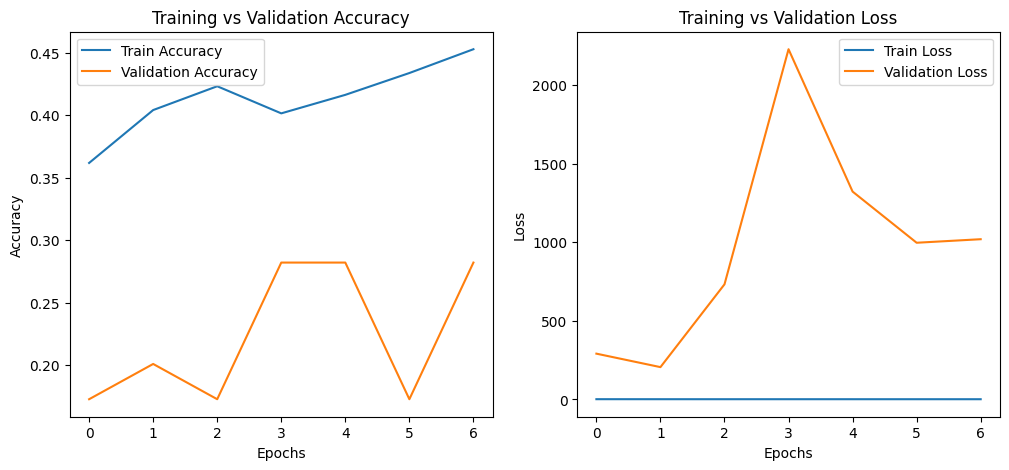

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history7.history['accuracy'], label='Train Accuracy')
plt.plot(history7.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training vs Validation Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history7.history['loss'], label='Train Loss')
plt.plot(history7.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')

plt.show()